# 9.1 图像增广

In [1]:
%matplotlib inline
import os
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(device)

1.5.0
cuda


## 9.1.1 常用的图像增广方法

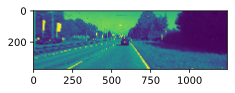

In [2]:
d2l.set_figsize()
img = Image.open('/home/messier/Pictures/2011_09_26/2011_09_26_drive_0015_sync/image_01/data/0000000057.png')
d2l.plt.imshow(img)

In [3]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [4]:
def apply(img, aug, num_rows=2, num_cols=4, scale=3):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

### 9.1.1.1 翻转和裁剪

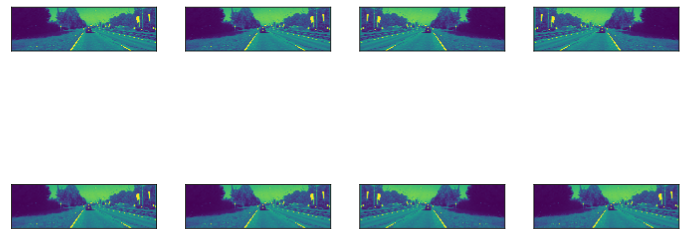

In [5]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

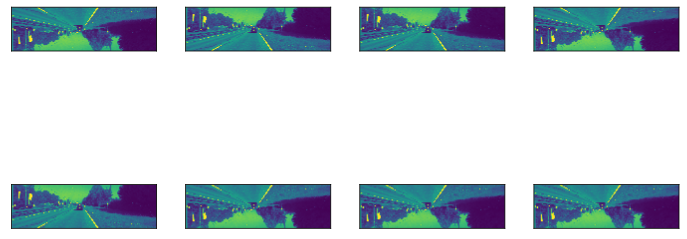

In [6]:
apply(img, torchvision.transforms.RandomVerticalFlip())

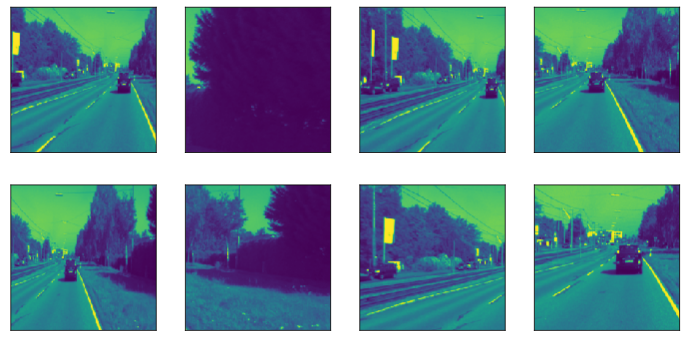

In [7]:
shape_aug = torchvision.transforms.RandomResizedCrop(200, scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### 9.1.1.2 变化颜色

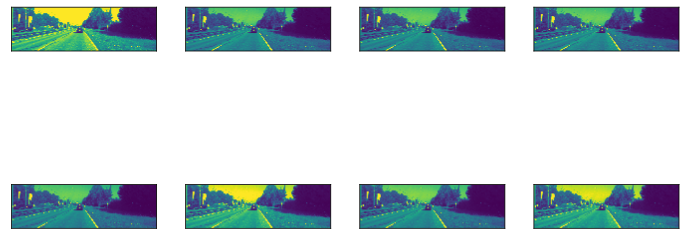

In [8]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

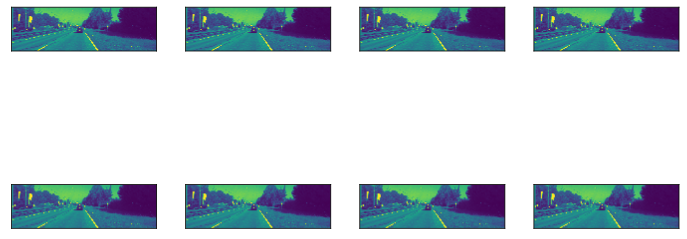

In [9]:
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

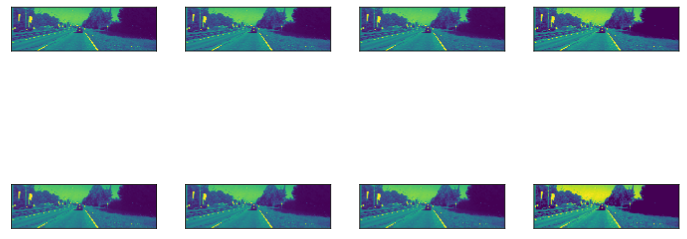

In [10]:
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0.5, saturation=0, hue=0))

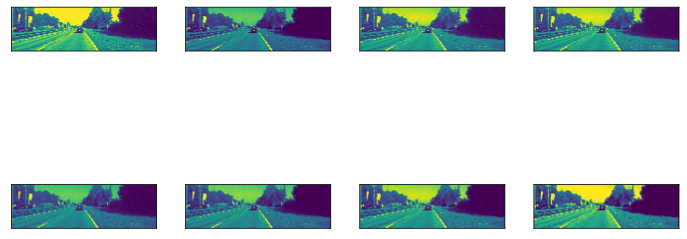

In [11]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### 9.1.1.3 叠加多个图像增广方法

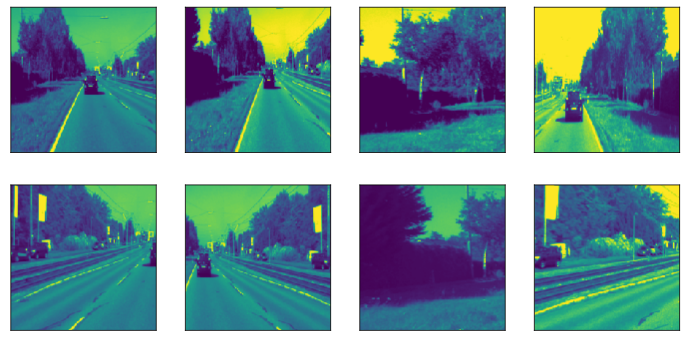

In [12]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

## 9.1.2 使用图像增广训练模型

Files already downloaded and verified


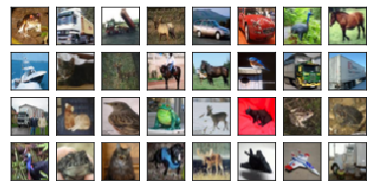

In [13]:
all_imges = torchvision.datasets.CIFAR10(train=True, root="~/Datasets/CIFAR", download=True)
# all_imges的每一个元素都是(image, label)
show_images([all_imges[i][0] for i in range(32)], 4, 8, scale=0.8);

In [14]:
flip_aug = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

no_aug = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [15]:
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size, root="~/Datasets/CIFAR"):
    dataset = torchvision.datasets.CIFAR10(root=root, train=is_train, transform=augs, download=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

### 9.1.2.1 使用图像增广训练模型

In [16]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = d2l.evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [17]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, net = 256, d2l.resnet18(10)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs=10)

In [18]:
train_with_data_aug(flip_aug, no_aug)

Files already downloaded and verified
Files already downloaded and verified
training on  cuda
epoch 1, loss 1.3921, train acc 0.497, test acc 0.510, time 19.0 sec
epoch 2, loss 0.5055, train acc 0.642, test acc 0.630, time 16.7 sec
epoch 3, loss 0.2840, train acc 0.701, test acc 0.597, time 16.8 sec
epoch 4, loss 0.1878, train acc 0.739, test acc 0.684, time 16.9 sec
epoch 5, loss 0.1340, train acc 0.765, test acc 0.602, time 16.9 sec
epoch 6, loss 0.1015, train acc 0.787, test acc 0.714, time 16.9 sec
epoch 7, loss 0.0793, train acc 0.807, test acc 0.701, time 16.8 sec
epoch 8, loss 0.0644, train acc 0.819, test acc 0.741, time 16.9 sec
epoch 9, loss 0.0521, train acc 0.838, test acc 0.707, time 16.8 sec
epoch 10, loss 0.0433, train acc 0.850, test acc 0.753, time 16.8 sec
